# Investigating Pi(2000) Throughput

In [2]:
# Loading event json
import json
import math
# Plotting the timeline
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

CPU-Centric:

Memory-Centric:

Mixed-Centric:

Spazio:
- Start = 1748364944
- End = 1748365030

Kube:
- Start = 1748374847
- End = 1748374940

In [112]:
experiments = {
    'spazio-mixed' : {
        'start' : 1748364944,
        'end' : 1748365030,
        'Name' : 'CARICO',
        'drop' : '10.244.23.28:32000'
    },
    'kube-mixed' : {
        'start' : 1748374847,
        'end' : 1748374940,
        'Name' : 'Default Scheduler',
        'drop' : '10.244.23.28:32000'
    }
}
keys = ['kube-mixed', 'spazio-mixed']

In [108]:
exp = 'spazio-mixed'

## Pod Completion

In [110]:
try:
    df = pd.read_csv(f'{exp}-pi-pod-completion.csv')
    df = df.drop(columns=['Time'])
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
single_row = df.iloc[0] # This will be a pandas Series

# Alternatively, convert the DataFrame to a NumPy array and flatten it
# single_row_array = df.to_numpy().flatten()

# 3. Create the histogram

# Method A: Using pandas built-in .hist() method (most straightforward)
plt.figure(figsize=(10, 6)) # Adjust figure size for better readability
single_row.hist(bins=50, edgecolor='black', alpha=0.7) # bins determines the number of bars
plt.title('Pod Completion over 3 batches of 1000x Pi-2000')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
# plt.savefig('figures/pi-2000-1000x-pod-completion.png')
plt.show()


In [102]:
statistical_summary = single_row.describe()

print("\n--- Statistical Summary (using .describe()) ---")
print(statistical_summary)

# 4. Customizing Percentiles (if you need specific ones)
# You can specify the percentiles you want using the 'percentiles' argument in describe()
custom_percentiles = single_row.describe(percentiles=[.01, .10, .25, .50, .75, .90, .99])

print("\n--- Statistical Summary with Custom Percentiles ---")
print(custom_percentiles)

# 5. Extracting individual percentiles if needed
# You can also get individual percentiles using the .quantile() method
p10 = single_row.quantile(0.10)
p90 = single_row.quantile(0.90)

print(f"\nValue at 10th percentile: {p10:.2f}")
print(f"Value at 90th percentile: {p90:.2f}")


--- Statistical Summary (using .describe()) ---
count    20.000000
mean     65.250000
std      10.527533
min      49.000000
25%      58.250000
50%      64.000000
75%      72.250000
max      82.000000
Name: 0, dtype: float64

--- Statistical Summary with Custom Percentiles ---
count    20.000000
mean     65.250000
std      10.527533
min      49.000000
1%       49.190000
10%      50.000000
25%      58.250000
50%      64.000000
75%      72.250000
90%      79.100000
99%      81.620000
max      82.000000
Name: 0, dtype: float64

Value at 10th percentile: 50.00
Value at 90th percentile: 79.10


## Pod Running

In [115]:
def read_running(name):
    try:
        df = pd.read_csv(f'{name}-pod-running.csv')
        df['Time'] = pd.to_datetime(df['Time'], unit='ms')
        df = df.set_index('Time')
        # df = df - 1
        # df.index = pd.to_datetime(df.index, errors='coerce')
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

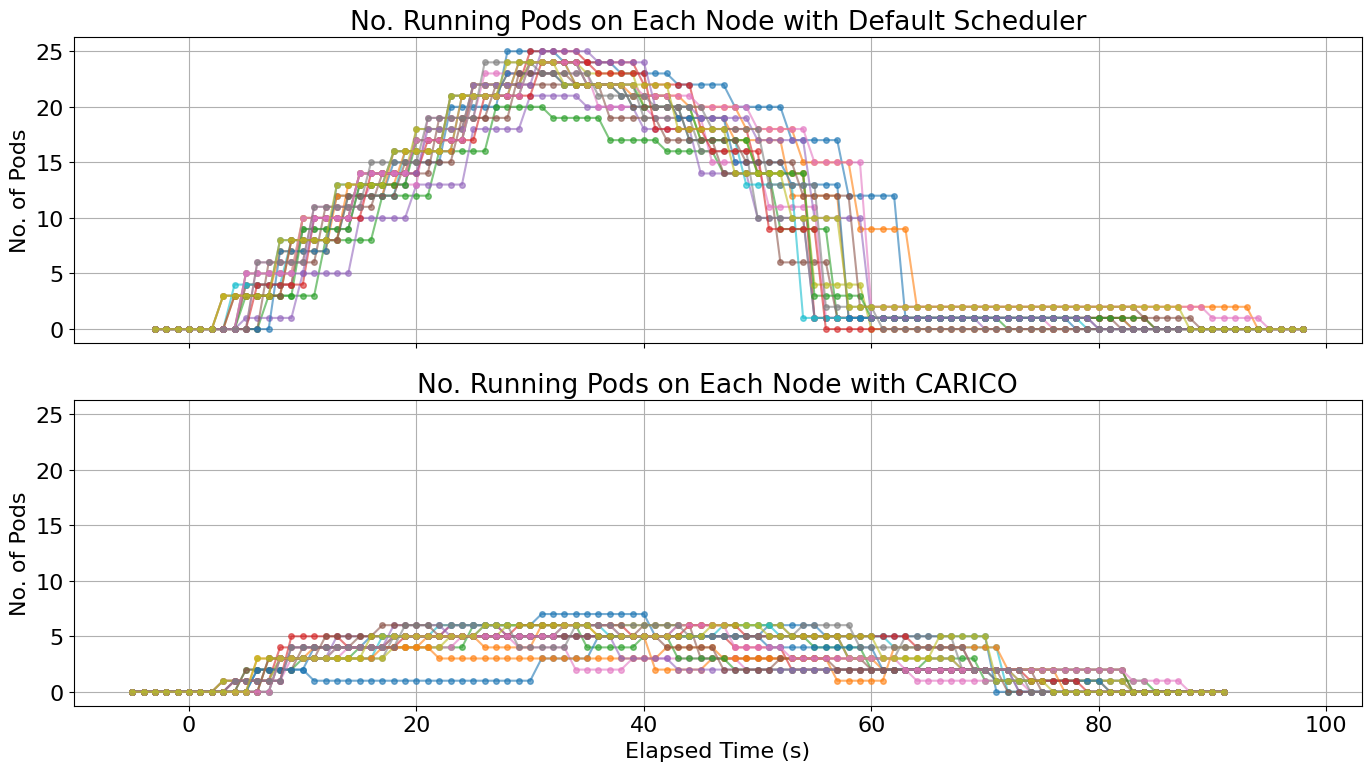

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(len(keys), 1, figsize=(14, 4 * len(keys)), sharex=True, sharey=True)
plt.rcParams['font.size'] = 16

for i in range(len(keys)):
    key = keys[i]
    df = read_running(key)
    if 'spazio' in key:
        df = df - 1
# 2. Slice the DataFrame to the restricted time range
# df.loc[start_dt:end_dt] directly works because df.index is now DatetimeIndex

    df_restricted = df.loc[pd.to_datetime(experiments[key]['start'] -5, unit='s'): pd.to_datetime(experiments[key]['end']+5, unit='s')]
    
    time_elapsed_seconds = (df_restricted.index - pd.to_datetime(experiments[key]['start'], unit='s')).total_seconds()
    df_restricted.index = time_elapsed_seconds
    if df_restricted.empty:
        print(f"\nNo data found for the specified time range: {start_dt} to {end_dt}. Please check your CSV data's time range.")
    else:
        # 3. Plot the number of pods on each node as a line graph
     
        df_restricted.plot(kind='line', marker='o', linestyle='-', ax=axes[i], markersize=4, alpha=0.6, legend=False) # Plot df_restricted directly
    
        axes[i].set_title(f'No. Running Pods on Each Node with {experiments[key]['Name']}')
        axes[i].set_xlabel('Elapsed Time (s)')
        axes[i].set_ylabel('No. of Pods')
        axes[i].grid(True)
        # plt.legend(title='Node', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside to avoid obscuring lines
    
        # # --- Original second graph (Stacked Area Plot of Total Pods by Node) ---
        # plt.figure(figsize=(12, 6))
        # df_restricted.plot(kind='area', stacked=True, ax=plt.gca(), cmap='viridis', legend=False)
        # plt.title('Running Pods Over Time (Stacked by Node)')
        # plt.xlabel('Elapsed Time (s)')
        # plt.ylabel('Total Pods')
        # plt.grid(True)
        # plt.xticks(rotation=45)
        # # plt.legend(title='Node', bbox_to_anchor=(1.05, 1), loc='upper left')
        # plt.tight_layout()
        # plt.show()

# plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'../figures/mixed-running-pods.png')    
plt.show()

## Resource Utilisation

In [105]:
def read_df(filepath):
    try:
        df = pd.read_csv(filepath)
        df['Time'] = pd.to_datetime(df['Time'], unit='ms')
        df = df.set_index('Time')
    
        # df.index = pd.to_datetime(df.index, errors='coerce')
        # df.info()

        return df
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

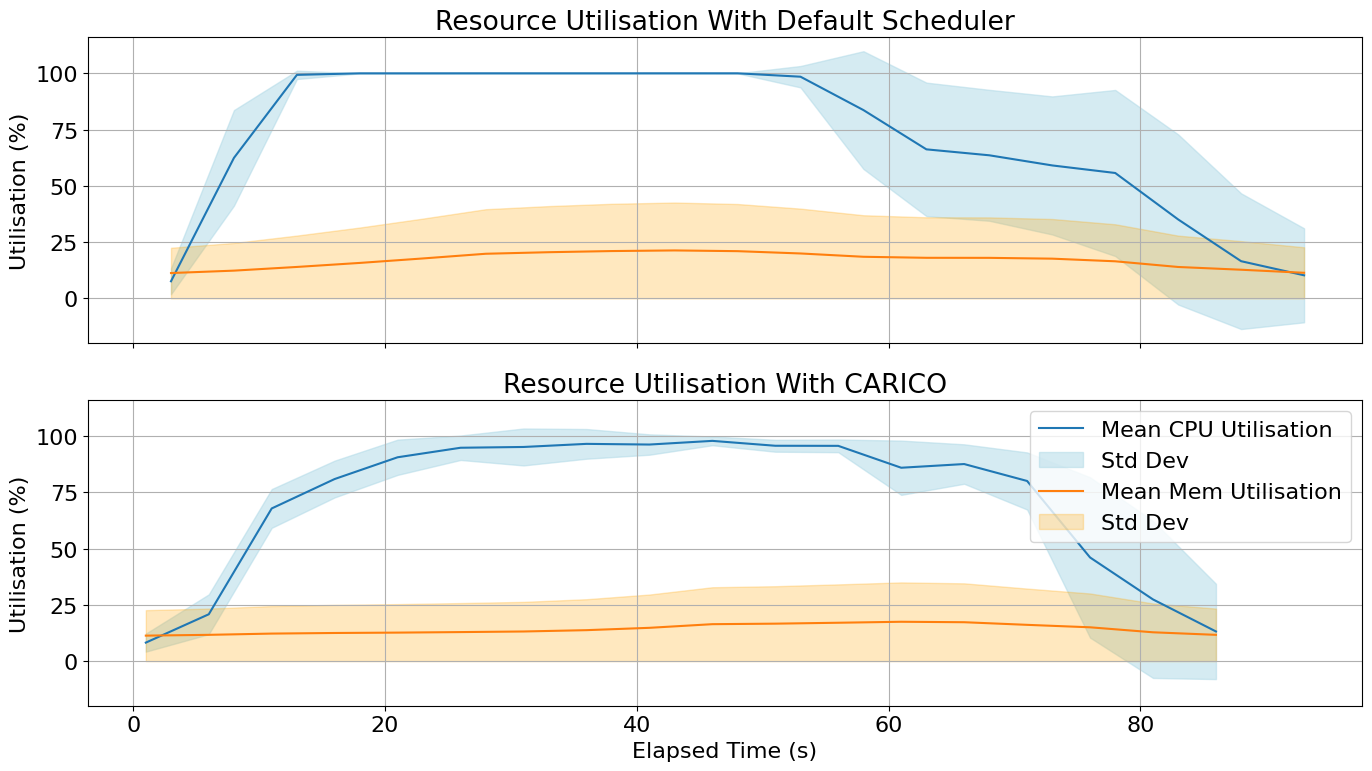

In [114]:
fig, axes = plt.subplots(len(keys), 1, figsize=(14, 4 * len(keys)), sharex=True, sharey=True)
plt.rcParams['font.size'] = 16

for i in range(len(keys)):
    key = keys[i]
    df = read_running(key)
# 2. Slice the DataFrame to the restricted time range
# df.loc[start_dt:end_dt] directly works because df.index is now DatetimeIndex

    cpu = read_df(f'{key}-cpu-util.csv')
    mem = read_df(f'{key}-mem-util.csv')
    mem = mem.drop(columns=[experiments[key]['drop']])
    
    # Calculate the mean CPU utilization across all machines for each time point
    cpu_mean = cpu.loc[pd.to_datetime(experiments[key]['start'], unit='s'): pd.to_datetime(experiments[key]['end'], unit='s')].mean(axis=1)
    cpu_time = (cpu_mean.index - pd.to_datetime(experiments[key]['start'], unit='s')).total_seconds()
    cpu_mean.index = cpu_time
    
    # Calculate the standard deviation of CPU utilization across all machines for each time point
    cpu_std = cpu.loc[pd.to_datetime(experiments[key]['start'], unit='s'): pd.to_datetime(experiments[key]['end'], unit='s')].std(axis=1)
    cpu_std.index = cpu_time
    
    mem_mean = mem.loc[pd.to_datetime(experiments[key]['start'], unit='s'): pd.to_datetime(experiments[key]['end'], unit='s')].mean(axis=1)
    mem_time = (mem_mean.index - pd.to_datetime(experiments[key]['start'], unit='s')).total_seconds()
    mem_mean.index = mem_time
    
    # Calculate the standard deviation of mem utilization across all machines for each time point
    mem_std = mem.loc[pd.to_datetime(experiments[key]['start'], unit='s'): pd.to_datetime(experiments[key]['end'], unit='s')].mean(axis=1)
    mem_std.index = mem_time
    
    # Plot the mean and standard deviation over time
    axes[i].plot(cpu_mean.index, cpu_mean, label='Mean CPU Utilisation')
    axes[i].fill_between(cpu_mean.index, cpu_mean - cpu_std,
                     cpu_mean + cpu_std, color='lightblue', alpha=0.5, label='Std Dev')
    axes[i].plot(mem_mean.index, mem_mean, label='Mean Mem Utilisation')
    axes[i].fill_between(mem_mean.index, mem_mean - mem_std,
                     mem_mean + mem_std, color='orange', alpha=0.25, label='Std Dev')
    # axes[i].tick_params(axis='x', labelbottom=False)
    axes[i].set_title(f'Resource Utilisation With {experiments[key]['Name']}')
    axes[i].set_ylabel('Utilisation (%)')
    axes[i].grid(True)

axes[len(keys)-1].set_xlabel('Elapsed Time (s)')
axes[len(keys)-1].legend()
plt.tight_layout()
plt.savefig(f'../figures/mixed-util.png')
plt.show()

In [111]:
read_df(f'{key}-mem-util.csv')

,10.244.1.173:32000,10.244.20.254:32000,10.244.21.15:32000,10.244.22.190:32000,10.244.23.28:32000,10.244.24.156:32000,10.244.25.199:32000,10.244.26.148:32000,10.244.28.200:32000,10.244.29.56:32000,10.244.30.88:32000,10.244.31.26:32000,10.244.32.247:32000,10.244.33.120:32000,10.244.34.173:32000,10.244.36.32:32000,10.244.37.129:32000,10.244.38.32:32000,10.244.39.131:32000
Time,,,,,,,,,,,,,,,,,,,
2025-05-27 19:40:40,10.069017,10.506635,13.123581,10.640630,22.602563,11.402477,10.460913,10.849865,10.978799,10.686465,12.590960,10.600698,10.944617,11.042501,12.281970,11.260038,10.324968,10.608428,12.068421
2025-05-27 19:40:45,10.090730,10.506610,13.059154,10.640630,22.617580,11.399375,10.464015,10.865473,10.978799,10.686465,12.626608,10.605327,10.944617,11.042501,12.143809,11.259989,10.331172,10.583859,12.069898
2025-05-27 19:40:50,10.554968,10.752503,13.069617,10.640630,22.619451,11.380369,10.404462,10.880417,11.562658,10.686465,12.907656,10.822809,10.967882,11.081473,12.211954,11.113630,10.436491,10.589718,12.120735
2025-05-27 19:40:55,11.613309,11.716919,13.427697,11.273825,26.858311,12.572016,11.315751,11.698597,12.443715,11.597950,13.706782,11.735107,11.830228,12.226910,13.340381,14.312151,11.678188,11.635425,13.281880
2025-05-27 19:41:00,12.326443,14.357580,19.469022,12.358159,32.114466,13.748005,12.402571,12.732364,13.418866,12.465835,14.706674,13.073162,12.925591,12.999890,14.360362,19.131154,13.576887,12.529210,14.379041
2025-05-27 19:41:05,13.278676,18.876802,21.503370,13.188723,33.249096,14.483540,16.818786,13.708277,14.357999,13.217249,15.903172,17.736771,13.862852,13.981957,15.001706,20.260737,18.659212,13.353792,14.981314
2025-05-27 19:41:10,14.255183,20.440859,22.370591,14.122094,34.893359,15.295418,19.848767,14.480051,15.031421,15.636043,18.794058,21.155162,17.223781,14.769709,15.855855,23.194483,24.452331,14.028445,17.886650
2025-05-27 19:41:15,15.097296,21.109333,23.073039,14.972772,36.450865,15.942153,20.857964,15.521155,15.751693,20.054693,21.589473,25.356701,20.795595,15.690229,16.902941,26.897345,26.306740,15.075063,25.429745
2025-05-27 19:41:20,15.420394,21.220905,23.274494,15.673816,36.978027,16.427069,21.285445,15.917197,15.523920,21.295627,22.776640,26.577768,21.804201,15.825854,17.350856,27.854055,27.219432,15.159062,28.272796
